### About
- This notebook summarize the following datasets.
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [6]:
import os
import numpy as np
from pathlib import Path
import re
from imageio import imread
import matplotlib.pyplot as plt

In [7]:
data_dir = Path('../../data/nyu_depth_v2_raw')
scenes = os.listdir(data_dir)
len(scenes)

590

### For bedroom 28

In [8]:
sample = 'bedroom_0028'
files = os.listdir(data_dir / sample)

pgms = [f for f in files if '.pgm' in f and 'd-' in f]
ppms = [f for f in files if '.ppm' in f and 'r-' in f]

print('number of pgms: ', len(pgms), 'number of ppms: ', len(ppms))

number of pgms:  552 number of ppms:  551


### Read .pgm images
- Reference
    - https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm

In [9]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

### Depth image sample
- .pgm format
- filename with prefix d-

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


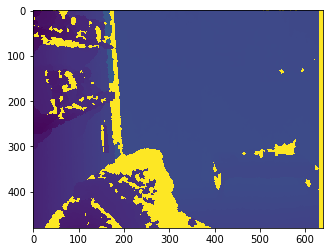

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


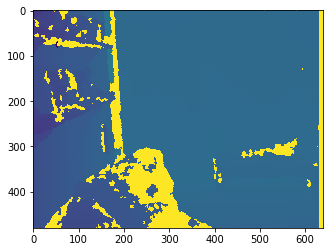

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


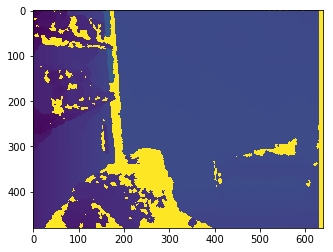

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


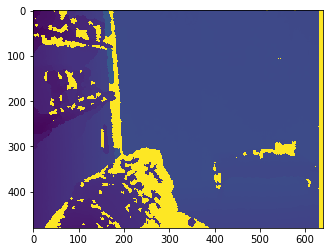

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


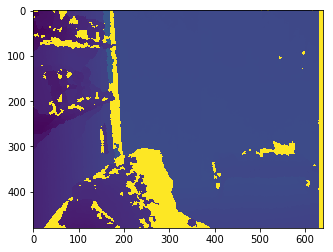

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


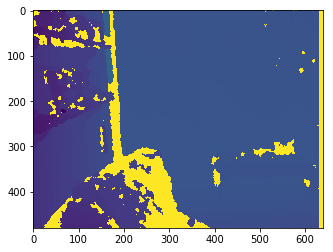

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


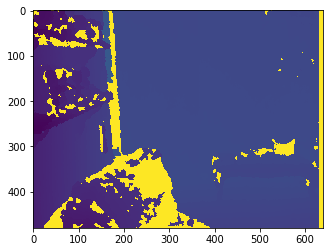

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


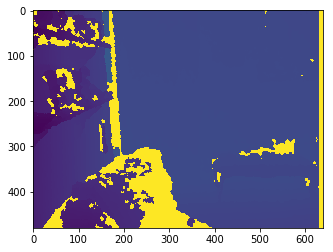

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


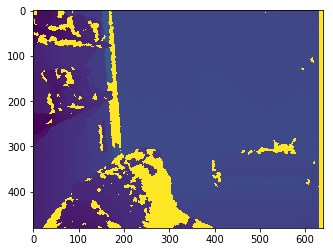

image shape:  (480, 640) image type:  <class 'numpy.ndarray'>


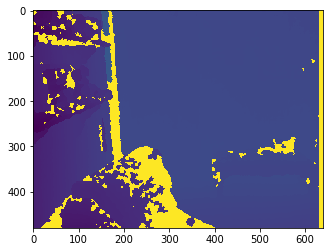

In [10]:
for pgm in pgms[-10:]:
    image = read_pgm(data_dir / sample / pgm, byteorder='<')
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()

### RGB image sample
- .ppm format
- filename with prefix r-

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


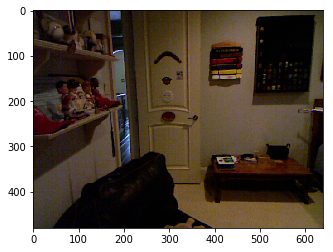

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


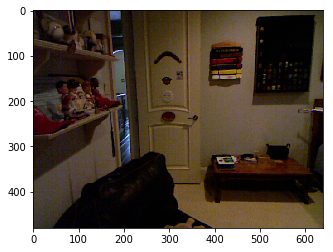

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


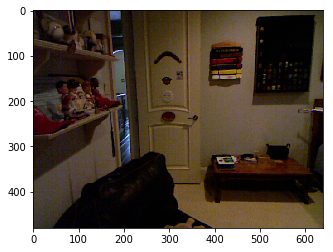

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


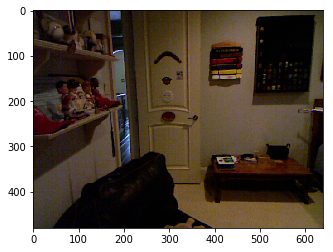

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


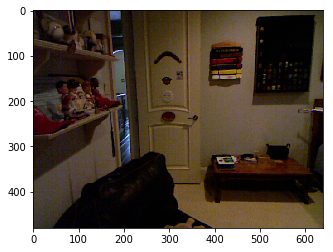

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


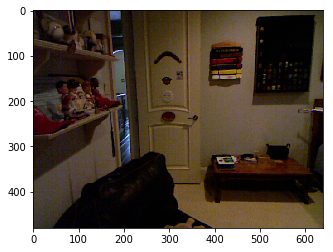

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


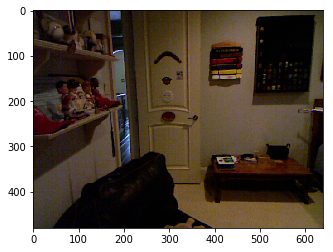

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


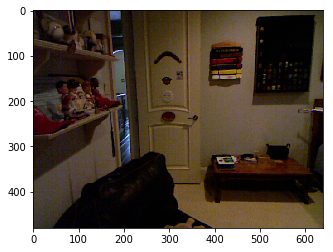

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


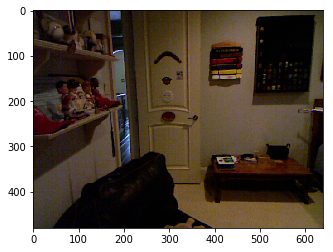

image shape:  (480, 640, 3) image type:  <class 'imageio.core.util.Array'>


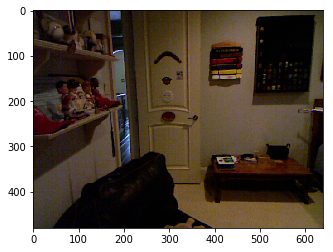

In [11]:
for ppm in ppms[-10:]:
    image = imread(data_dir / sample / 'r-1315330905.145428-2609308254.ppm')
    print('image shape: ', image.shape, 'image type: ', type(image))
    plt.imshow(image)
    plt.show()